<a href="https://colab.research.google.com/github/luixmartins/data-science-projects/blob/main/large-text-research-bert/bbc_articles_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U sentence-transformers -q 

     |████████████████████████████████| 85 kB 3.9 MB/s 
     |████████████████████████████████| 4.4 MB 21.6 MB/s 
     |████████████████████████████████| 1.2 MB 62.3 MB/s 
     |████████████████████████████████| 101 kB 9.5 MB/s 
     |████████████████████████████████| 596 kB 17.7 MB/s 
     |████████████████████████████████| 6.6 MB 48.7 MB/s 


In [15]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA  
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split 
from sklearn.metrics import confusion_matrix, classification_report 

%matplotlib inline 

In [3]:
class dimensionality_reduction_bert:
  def __init__(self):
    self.model = SentenceTransformer('nli-distilroberta-base-v2')
    self.pca = PCA(n_components=1)

  def preprocessing(self, text):
    return text.split(". ")

  def encode_text(self, text):
    return self.model.encode(text).T

  def fit(self, text: str):
    text_processed = self.preprocessing(text)
    text_encoded = self.encode_text(text_processed)

    return self.pca.fit_transform(text_encoded).T
  
  def fit_transform(self, items: list):
    return list(map(self.fit, items))

In [21]:
path = "https://raw.githubusercontent.com/luixmartins/data-science-projects/main/large-text-research-bert/datasets/bbc_news_train.csv"

df = pd.read_csv(path, usecols=[1, 2])
df.head()

,Text,Category
0,worldcom ex-boss launches defence lawyers defe...,business
1,german business confidence slides german busin...,business
2,bbc poll indicates economic gloom citizens in ...,business
3,lifestyle governs mobile choice faster bett...,tech
4,enron bosses in $168m payout eighteen former e...,business


In [23]:
def normalize_category(text):
  if text == 'business':
    return 0
  elif text == 'tech':
    return 1
  elif text == 'politics':
    return 2
  elif text == 'sport':
    return 3 
  elif text == 'entertainment':
    return 4
  
df.Category = df.Category.apply(lambda text: normalize_category(text))

df.Category.unique()

array([0, 1, 2, 3, 4])

In [24]:
X = [text for text in df.Text.values]
y = [i for i in df.Category.values]

drb = dimensionality_reduction_bert()

X = drb.fit_transform(X)
X = np.array(X).reshape(len(X), len(X[0][0]))

X.shape

(1490, 768)

In [25]:
models = [
          RandomForestClassifier(n_estimators=100, max_depth=5),
          MLPClassifier(),
          KNeighborsClassifier(),
          SVC(),
          GaussianNB(),
]

cv_df = pd.DataFrame(index=range(5 * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=5)

  for fold_index, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_index, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_index', 'accuracy'])

mean = cv_df.groupby('model_name').accuracy.mean()
std = cv_df.groupby('model_name').accuracy.std()

result_cv = pd.concat([mean, std], axis=1, ignore_index=True)
result_cv.columns = ['Mean Accuracy', 'Standard Deviation']

result_cv 

,Mean Accuracy,Standard Deviation
model_name,,
GaussianNB,0.805369,0.033557
KNeighborsClassifier,0.940268,0.020604
MLPClassifier,0.958389,0.021565
RandomForestClassifier,0.864430,0.020495
SVC,0.955705,0.015988


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [27]:
clf = SVC(kernel='poly', degree=2)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, output_dict=False))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93        84
           1       0.97      0.92      0.94        65
           2       0.93      0.91      0.92        69
           3       0.98      1.00      0.99        87
           4       0.96      0.97      0.96        68

    accuracy                           0.95       373
   macro avg       0.95      0.95      0.95       373
weighted avg       0.95      0.95      0.95       373



Text(51.0, 0.5, 'True')

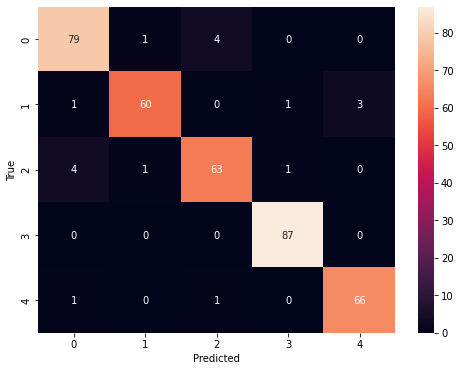

In [28]:
cf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')